### Load in Packages and Set Up Parameters

In [1]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Next, let’s install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI’s GPT and GPT-2.) We’ve selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don’t provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

In [4]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Load in Data

In [5]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train_f = pd.read_csv("/kaggle/input/gcld-nort-bert/df_train_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

# Import Test and Measure Balance

df_test_f = pd.read_csv("/kaggle/input/gcld-nort-bert/df_test_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

# Import Validation and Measure Balance
# Import Flattened Data
df_valid_f = pd.read_csv("/kaggle/input/gcld-nort-bert/df_valid_full_cleaned_pe.csv", encoding='utf_8_sig', low_memory=False)

In [6]:
df_train_f.head(6)

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.description,user.favourites_count,...,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True
0,'1.2781248368924918e+18',1.593564e+09,今天第一次上推特，看看世界,0.0,1.0,0,1.278122e+18,1.593563e+09,关心政治,0.0,...,1,0,1,0,1,1,1,1,1,0
1,'1.2797572269916938e+18',1.593953e+09,@ttingxiao 胡说八道,0.0,0.0,0,1.278122e+18,1.593563e+09,关心政治,0.0,...,1,0,1,0,1,1,1,1,1,0
2,'1.2818699475099935e+18',1.594457e+09,@VijayShankarKu1 @zlj517 Are you describing In...,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
3,'1.2803084709364818e+18',1.594084e+09,"@auighur @realDonaldTrump just like Trump,with...",0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
4,'1.2818669493543813e+18',1.594456e+09,@USA_China_Talk 不依法治国，难道还以推治国？美国鼓吹的宪法精神又到哪了？,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0
5,'1.2811047401018737e+18',1.594274e+09,@grass9fish @SUMANsaurabh07 +1,0.0,0.0,0,1.278129e+18,1.593565e+09,中华人民共和国战略忽悠局北美司情资一处国家二级忽悠师,41.0,...,1,0,1,0,1,1,1,1,1,0


In [7]:
df_train_f['id'] = df_train_f['id'].apply(lambda x: x.replace("'", ''))
df_train_f['id'] = df_train_f['id'].astype('float')
df_valid_f['id'] = df_valid_f['id'].apply(lambda x: x.replace("'", ''))
df_valid_f['id'] = df_valid_f['id'].astype('float')
df_test_f['id'] = df_test_f['id'].apply(lambda x: x.replace("'", ''))
df_test_f['id'] = df_test_f['id'].astype('float')

In [8]:
print("full train:", len(df_train_f), "unique ids train:", len(df_train_f['id'].unique()), 
      "full valid:", len(df_valid_f), "unique ids valid:", len(df_valid_f['id'].unique()), 
      "full test:", len(df_test_f), "unique ids test:", len(df_test_f['id'].unique()))

#print("Train:", len(sentences_train), "Valid:", len(sentences_valid), "Test", len(sentences_test))

full train: 79711 unique ids train: 79711 full valid: 27077 unique ids valid: 27077 full test: 20275 unique ids test: 20275


In [9]:
df_train_full = df_train_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_valid_full = df_valid_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_test_full = df_test_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)

In [10]:
# FOR TESING OUT CODE PURPOSE ONLY. REMOVE ONCE ALL IS WORKING. 
#df_train_full = df_train_full[:5000]
#df_valid_full = df_valid_full[:5000]
#df_test_full = df_test_full[:5000]

In [11]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from numba import cuda 
import gc

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np

import time
import datetime
import random
import plotly.express as px
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Load in Model and Tokenizer

In [12]:
def langmodel(lang):
    if lang == 'en':
        mod = 'bert-base-cased' #
    elif lang == 'zh':
        mod = 'bert-base-chinese'
    elif lang == 'zh-Latn':
        mod = 'bert-base-chinese' #
    #elif lang == 'vi':
     #   mod = 'vinai/phobert-base'
    else:
        mod = 'bert-base-multilingual-cased'
    return mod

# https://akkefa.com/posts/2020/08/urdu-language-model-bert-based-by-urduhack-team/ - ?
# https://huggingface.co/monsoon-nlp/hindi-bert ? 

In [13]:
langmodels = ['bert-base-cased', 'bert-base-chinese', 'bert-base-multilingual-cased']
# 'vinai/phobert-base',

In [14]:
df_train_full['mod'] = df_train_full['lang'].apply(lambda x: langmodel(x))
df_valid_full['mod'] = df_valid_full['lang'].apply(lambda x: langmodel(x))
df_test_full['mod'] = df_test_full['lang'].apply(lambda x: langmodel(x))

In [15]:
for i in range(0, len(langmodels)):
    tt = df_train_full[df_train_full['mod'] == langmodels[i]]
    vv = df_valid_full[df_valid_full['mod'] == langmodels[i]]
    tete = df_test_full[df_test_full['mod'] == langmodels[i]]
    print("full train:", len(tt), "full valid:", len(vv), "full test:", len(tete))

full train: 19696 full valid: 9107 full test: 3868
full train: 8622 full valid: 2136 full test: 1885
full train: 51393 full valid: 15834 full test: 14522


In [16]:
def sent_to_ids(sentences, tokenizer): 
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    # For every sentence...
    for sent in sentences:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
            sent,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            # This function also supports truncation and conversion
            # to pytorch tensors, but we need to do padding, so we
            # can't use these features :( .
            #max_length = 128,          # Truncate all sentences.
            #return_tensors = 'pt',     # Return pytorch tensors.
        )
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent)
        # Pad and truncate our sequences so that they all have the same length
    input_ids = pad_sequences(input_ids, maxlen=120, dtype="long", 
                            value=0, truncating="post", padding="post")
    return input_ids

In [17]:
def get_attn_msks(input_ids):
  # Create attention masks
    attention_masks = []
  # For each sentence...
    for sent in input_ids:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]
      
        # Store the attention mask for this sentence.
        attention_masks.append(att_mask)
    return attention_masks

In [18]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
def monolingual_models(df_train, df_valid, df_test, model_name):
    df_train = df_train[df_train['mod'] == model_name]
    df_valid = df_valid[df_valid['mod'] == model_name]
    df_test = df_test[df_test['mod'] == model_name]
    
     # Load the BERT tokenizer.
    print('Loading BERT tokenizer...')
    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
    
    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, model_name)

    # Load pretrained model/tokenizer
    #tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    #model = model_class.from_pretrained(pretrained_weights)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    # Get the lists of sentences and their labels.
    sentences_train = df_train.text.values
    train_labels = df_train.suspended.values
    ids_train = df_train.id.values

    sentences_valid = df_valid.text.values
    validation_labels = df_valid.suspended.values
    ids_validation = df_valid.id.values

    sentences_test = df_test.text.values
    test_labels = df_test.suspended.values
    ids_test = df_test.id.values
    
    print("Train:", len(sentences_train), "Valid:", len(sentences_valid), "Test", len(sentences_test))
    
    train_inputs = sent_to_ids(sentences_train, tokenizer)
    
    validation_inputs = sent_to_ids(sentences_valid, tokenizer)
    
    test_inputs = sent_to_ids(sentences_test, tokenizer)
    
    print("Train:", len(train_inputs), "Valid:", len(validation_inputs), "Test", len(test_inputs))
    
    train_masks = get_attn_msks(train_inputs)
    
    validation_masks = get_attn_msks(validation_inputs)
    
    test_masks = get_attn_msks(test_inputs)
    
    # Convert all inputs and labels into torch tensors, the required datatype 
    # for our model.
    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)

    train_ids = torch.tensor(ids_train)
    valid_ids = torch.tensor(ids_validation)
    
    print("Train:", len(train_inputs), "Valid:", len(validation_inputs), "Test", len(test_inputs))
    
    # For Test
    # Convert to tensors.
    prediction_inputs = torch.tensor(test_inputs)
    prediction_masks = torch.tensor(test_masks)
    prediction_labels = torch.tensor(test_labels)
    prediction_ids = torch.tensor(ids_test)

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels, prediction_ids)
    prediction_sampler = SequentialSampler(prediction_data)
    # Set the batch size.  
    batch_size = 4 
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    
    prediction_inputs.shape
    
    # The DataLoader needs to know our batch size for training, so we specify it 
    # here.
    # For fine-tuning BERT on a specific task, the authors recommend a batch size of
    # 16 or 32.
    batch_size = 16 # try 32, and then move down to 16 and 8. 
    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels, train_ids)
    train_sampler = RandomSampler(train_data) # CHANGE TO SEQUENTIAL (TRAIN_SEQUENTIAL_SAMPLER - BUT DO SEQUENTIALLY FOR HIDDEN STATES)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, valid_ids)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Create the DataLoader for our training set for the embedding extraction.
    train_sampler_sequential = SequentialSampler(train_data) # CHANGE TO SEQUENTIAL (TRAIN_SEQUENTIAL_SAMPLER - BUT DO SEQUENTIALLY FOR HIDDEN STATES)
    train_dataloader_sequential = DataLoader(train_data, sampler=train_sampler_sequential, batch_size=batch_size)
    
    # Load BertForSequenceClassification, the pretrained BERT model with a single 
    # linear classification layer on top. 
    model = BertForSequenceClassification.from_pretrained(
        model_name, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = True, # Whether the model returns all hidden-states.
    )
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    
    # Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())
    print('The BERT model has {:} different named parameters.\n'.format(len(params)))
    print('==== Embedding Layer ====\n')
    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    print('\n==== First Transformer ====\n')
    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    print('\n==== Output Layer ====\n')
    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
        
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
    # I believe the 'W' stands for 'Weight Decay fix"
    # Cross entropy is used as the loss by default
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )
    
    # Number of training epochs (authors recommend between 2 and 4)
    epochs = 2
    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    # Store the average loss after each epoch so we can plot them.
    loss_values = []
    loss_values_valid = []
    #embeddings_tr, embeddings_vl = [], []
    train_predictions, valid_predictions = [], []
    train_true_labels, valid_true_labels = [], []
    # Store the hidden states for embedding extraction

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_loss = 0
        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        
            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs_a = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs_a[0]
            logits_tr = outputs_a[1]
            #hidden_state_tr = outputs_a[2]
            #features = hidden_state_tr[0][:,0,:].detach().cpu().numpy()
            #embeddings_tr.append([epoch_i,batch[3], features]) # FIX AS NO BACKPROP WEIGHT ADJUSTED
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            # Move logits, hidden states, and labels to CPU
            logits_tr = logits_tr.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            #train_predictions.append([epoch_i,logits_tr])
            #train_true_labels.append([epoch_i,label_ids])

            total_loss += loss.item()
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()
            # Update the learning rate.
            scheduler.step()
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
        print("")
        print("Running Validation...")
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Add batch to GPU
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)

            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss = outputs[0]
            logits = outputs[1]
            #hidden_state_vl = outputs[2]
            #features = hidden_state_vl[0][:,0,:].detach().cpu().numpy()
            #embeddings_vl.append([epoch_i,batch[3], features])

            # Track Loss
            eval_loss += loss.item()

            # Move logits, hidden states, and labels to CPU
            logits = logits.detach().cpu().numpy()
            #hidden_state_vl = hidden_state_vl.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            valid_predictions.append([epoch_i,logits]) ####################################
            valid_true_labels.append([epoch_i,label_ids]) ####################################

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        # Calculate the average loss over the training data.
        avg_valid_loss = eval_loss / len(validation_dataloader)   

        # Report the final accuracy for this validation run.
        loss_values_valid.append(avg_valid_loss)
        print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
        print("  Average validation loss: {0:.2f}".format(avg_valid_loss))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Training complete!")
    
    df= pd.DataFrame({'epoch': range(0, epochs), 'Train Loss': loss_values, 'Valid Loss': loss_values_valid})
    df = pd.melt(df, id_vars=['epoch'], value_vars=['Train Loss', 'Valid Loss'])
    
    fig = px.line(df, x='epoch', y='value', color = 'variable')
    fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
    fig.show()
    
    embeddings_tr, embeddings_vl = [], []
    # ========================================
    #               Train
    # ========================================
    # Extract embeddinga on train set
    print('Extracting embeddinga for {:,} train sentences...'.format(len(train_inputs)))
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    predictions_train , true_labels_train = [], []
    # Predict 
    for batch in train_dataloader_sequential:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
        # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
        hidden_state_tr = outputs[2]
        token_vecs = hidden_state_tr[-2]
        token_vecs_sentvecs = []
        for token in token_vecs:
            sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
            token_vecs_sentvecs.append(sentvecs)
        #features = hidden_state_tr[0][:,0,:].detach().cpu().numpy()
        embeddings_tr.append([batch[3], token_vecs_sentvecs])
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions_train.append(logits) ####################################
        true_labels_train.append(label_ids) ####################################
    # ========================================
    #               Validation
    # ========================================
    # Extract embeddinga on train set
    print('Extracting embeddings for {:,} validation sentences...'.format(len(validation_inputs)))
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    predictions_valid, true_labels_valid = [], []
    # Predict 
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
        # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
        hidden_state_vl = outputs[2]
        token_vecs = hidden_state_vl[-2]
        token_vecs_sentvecs = []
        for token in token_vecs:
            sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
            token_vecs_sentvecs.append(sentvecs)
        #features = hidden_state_vl[0][:,0,:].detach().cpu().numpy()
        embeddings_vl.append([batch[3], token_vecs_sentvecs])
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions_valid.append(logits) ####################################
        true_labels_valid.append(label_ids) #################################
        
    embeddings_te = []
    # Prediction on test set
    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in prediction_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        # Embeddings extraction approach is to average the second to last hiden layer of each token producing a single 768 length vector
        # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
        hidden_state_te = outputs[2]
        token_vecs = hidden_state_te[-2]
        token_vecs_sentvecs = []
        for token in token_vecs:
            sentvecs = torch.mean(token, dim=0).detach().cpu().numpy()
            token_vecs_sentvecs.append(sentvecs)
        # features = hidden_state_te[12][:,0,:].detach().cpu().numpy()
        embeddings_te.append([batch[3], token_vecs_sentvecs])
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
    return embeddings_tr, predictions_train, true_labels_train, embeddings_vl, predictions_valid, true_labels_valid, embeddings_te, predictions, true_labels, model, tokenizer, df_train, df_valid, df_test 

In [21]:
def get_embeddings(embeddings_tr, embeddings_vl, embeddings_te, df_train, df_valid, df_test, model_name, model, tokenizer):
    # Get embeddings for train
    p = [group for group in embeddings_tr]

    b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
    df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

    bert_embeddings_df_train = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
    bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.item())
    #bert_embeddings_df_train = pd.merge(df_train.drop(['text'], axis=1), bert_embeddings_df_train, left_on = ["id"], right_on = ["id"])
    bert_embeddings_df_train = pd.merge(df_train.drop(['text'], axis=1), bert_embeddings_df_train.drop(['id'], axis=1), left_index=True, right_index=True)
    print('Train Embeddings Extraction and Merge DONE')
    bert_embeddings_df_train.head()
        
    # Get embeddings for valid
    p = [group for group in embeddings_vl]

    b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
    df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

    bert_embeddings_df_valid = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
    bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.item())
    #bert_embeddings_df_valid = pd.merge(df_valid.drop(['text'], axis=1), bert_embeddings_df_valid, left_on = ["id"], right_on = ["id"])
    bert_embeddings_df_valid = pd.merge(df_valid.drop(['text'], axis=1), bert_embeddings_df_valid.drop(['id'], axis=1), left_index=True, right_index=True)
    print('Valid Embeddings Extraction and Merge DONE.')
    bert_embeddings_df_valid.head()
    
    bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].astype('str')
    bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: "'" + x + "'")
    bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].astype('str')
    bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: "'" + x + "'")
    
    print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['id'].unique()))
    
    model_to_save = model.module if hasattr(model, "module") else model # Take care of distributed/parallel training
    model_to_save.save_pretrained('./Multilingual_Tweettext_mode/'+ model_name + '/')
    tokenizer.save_pretrained('./Multilingual_Tweettext_mode/' + model_name + '/')
    
    # Get embeddings for test
    p = [group for group in embeddings_te]

    b = [item for sublist in [[list(t) for t in zip(sublist[0], sublist[1])] for sublist in p] for item in sublist]
    df = pd.DataFrame(b, columns = ['id', 'embeddings'])  

    bert_embeddings_df_test = pd.concat([df['id'], df['embeddings'].apply(pd.Series)], axis = 1)
    bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.item())
    #bert_embeddings_df_test = pd.merge(df_test.drop(['text'], axis=1), bert_embeddings_df_test, left_on = ["id"], right_on = ["id"])
    bert_embeddings_df_test = pd.merge(df_test.drop(['text'], axis=1), bert_embeddings_df_test.drop(['id'], axis=1), left_index=True, right_index=True)
    print('DONE.')
    bert_embeddings_df_test.head()

    bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].astype('str')
    bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: "'" + x + "'")

    print("full train:", len(bert_embeddings_df_test), "unique ids train:", len(bert_embeddings_df_test['id'].unique()))
    
    return bert_embeddings_df_train, bert_embeddings_df_valid, bert_embeddings_df_test

In [22]:
def get_preds(predictions_train, true_labels_train, predictions_valid, true_labels_valid, predictions, true_labels):
    # Train
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions_train = [item for sublist in predictions_train for item in sublist]
    flat_predictions_train = np.argmax(flat_predictions_train, axis=1).flatten()
    # Combine the correct labels for each batch into a single list.
    flat_true_labels_train = [item for sublist in true_labels_train for item in sublist]
    
    # Valid 
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions_valid = [item for sublist in predictions_valid for item in sublist]
    flat_predictions_valid = np.argmax(flat_predictions_valid, axis=1).flatten()
    # Combine the correct labels for each batch into a single list.
    flat_true_labels_valid = [item for sublist in true_labels_valid for item in sublist]
    
    # Test
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions_test = [item for sublist in predictions for item in sublist]
    flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
    # Combine the correct labels for each batch into a single list.
    flat_true_labels_test = [item for sublist in true_labels for item in sublist]
    
    return flat_predictions_train, flat_true_labels_train, flat_predictions_valid, flat_true_labels_valid, flat_predictions_test, flat_true_labels_test
    

In [23]:
def get_accs(flat_true_labels, flat_predictions):
    report = classification_report(flat_true_labels, flat_predictions)
    print(report)

Save

In [24]:
def combined_models(df_train, df_valid, df_test,langmodels):
    full_train_embeddings, full_valid_embeddings, full_test_embeddings = [], [], []
    full_train_labels, full_valid_labels, full_test_labels = [], [], []
    full_train_predictions, full_valid_predictions, full_test_predictions = [], [], []
    for i in range(0, len(langmodels)):
        embeddings_tr, predictions_train, true_labels_train, embeddings_vl, predictions_valid, true_labels_valid, embeddings_te, predictions, true_labels, model, tokenizer, df_train_sub, df_valid_sub, df_test_sub = monolingual_models(df_train, df_valid, df_test, langmodels[i])
        bert_embeddings_df_train, bert_embeddings_df_valid, bert_embeddings_df_test = get_embeddings(embeddings_tr, embeddings_vl, embeddings_te, df_train_sub, df_valid_sub, df_test_sub, langmodels[i], model, tokenizer)
        full_train_embeddings.append(bert_embeddings_df_train)
        full_valid_embeddings.append(bert_embeddings_df_valid)
        full_test_embeddings.append(bert_embeddings_df_test)
        full_train_labels.append(true_labels_train)
        full_valid_labels.append(true_labels_valid)
        full_test_labels.append(true_labels)
        full_train_predictions.append(predictions_train)
        full_valid_predictions.append(predictions_valid)
        full_test_predictions.append(predictions)
    full_train_predictions_all = [item for sublist in full_train_predictions for item in sublist]
    full_valid_predictions_all = [item for sublist in full_valid_predictions for item in sublist]
    full_test_predictions_all = [item for sublist in full_test_predictions for item in sublist]
    full_train_labels_all = [item for sublist in full_train_labels for item in sublist]
    full_valid_labels_all = [item for sublist in full_valid_labels for item in sublist]
    full_test_labels_all = [item for sublist in full_test_labels for item in sublist]
    full_train_embeddings_all = pd.concat(full_train_embeddings, ignore_index=True)
    full_valid_embeddings_all = pd.concat(full_valid_embeddings, ignore_index=True) 
    full_test_embeddings_all = pd.concat(full_test_embeddings, ignore_index=True) 
    
    full_train_embeddings_all.to_csv('ml_training_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")
    full_valid_embeddings_all.to_csv('ml_valid_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")
    full_test_embeddings_all.to_csv('ml_test_embeddings_df_full.csv', index=False, encoding = "utf_8_sig")

    return full_train_embeddings_all, full_valid_embeddings_all, full_test_embeddings_all, full_train_labels_all, full_valid_labels_all, full_test_labels_all, full_train_predictions_all, full_valid_predictions_all, full_test_predictions_all

In [25]:
full_train_embeddings_all,  full_valid_embeddings_all, full_test_embeddings_all, full_train_labels_all, full_valid_labels_all, full_test_labels_all, full_train_predictions_all, full_valid_predictions_all, full_test_predictions_all = combined_models(df_train_full, df_valid_full, df_test_full, langmodels)

Loading BERT tokenizer...



Train: 19696 Valid: 9107 Test 3868
Train: 19696 Valid: 9107 Test 3868
Train: 19696 Valid: 9107 Test 3868


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Extracting embeddinga for 19,696 train sentences...
Extracting embeddings for 9,107 validation sentences...
Predicting labels for 3,868 test sentences...
Train Embeddings Extraction and Merge DONE
Valid Embeddings Extraction and Merge DONE.
full train: 4303 unique ids train: 4303 full valid: 2085 unique ids valid: 2085
DONE.
full train: 507 unique ids train: 507
Loading BERT tokenizer...



Train: 8622 Valid: 2136 Test 1885
Train: 8622 Valid: 2136 Test 1885
Train: 8622 Valid: 2136 Test 1885


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (21128, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Extracting embeddinga for 8,622 train sentences...
Extracting embeddings for 2,136 validation sentences...
Predicting labels for 1,885 test sentences...
Train Embeddings Extraction and Merge DONE
Valid Embeddings Extraction and Merge DONE.
full train: 764 unique ids train: 764 full valid: 218 unique ids valid: 218
DONE.
full train: 111 unique ids train: 111
Loading BERT tokenizer...



Train: 51393 Valid: 15834 Test 14522
Train: 51393 Valid: 15834 Test 14522
Train: 51393 Valid: 15834 Test 14522


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Extracting embeddinga for 51,393 train sentences...
Extracting embeddings for 15,834 validation sentences...
Predicting labels for 14,522 test sentences...
Train Embeddings Extraction and Merge DONE
Valid Embeddings Extraction and Merge DONE.
full train: 34357 unique ids train: 34357 full valid: 9905 unique ids valid: 9905
DONE.
full train: 10783 unique ids train: 10783


In [26]:
flat_predictions_train, flat_true_labels_train, flat_predictions_valid, flat_true_labels_valid, flat_predictions_test, flat_true_labels_test = get_preds(full_train_predictions_all, full_train_labels_all, full_valid_predictions_all, full_valid_labels_all, full_test_predictions_all, full_test_labels_all)

In [27]:
get_accs(flat_true_labels_train, flat_predictions_train)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     71465
           1       0.93      0.44      0.59      8246

    accuracy                           0.94     79711
   macro avg       0.93      0.72      0.78     79711
weighted avg       0.94      0.94      0.93     79711



In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  

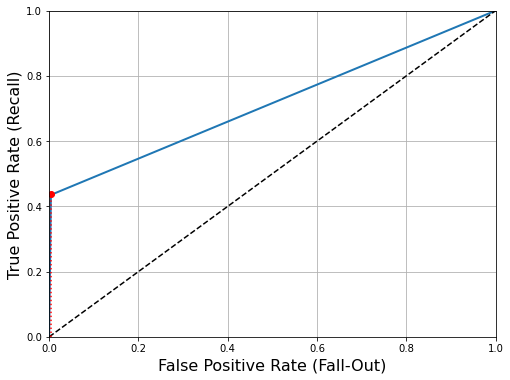

In [29]:
fpr, tpr, thresholds = roc_curve(flat_true_labels_train, flat_predictions_train)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [30]:
roc_auc_score(flat_true_labels_train, flat_predictions_train)

0.7156849853773217

In [31]:
get_accs(flat_true_labels_valid, flat_predictions_valid)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     23520
           1       0.19      0.03      0.05      3557

    accuracy                           0.85     27077
   macro avg       0.53      0.51      0.49     27077
weighted avg       0.78      0.85      0.81     27077



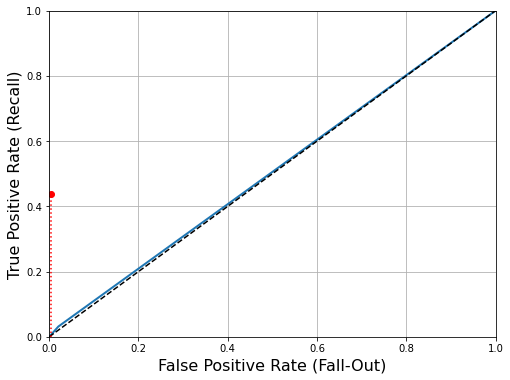

In [32]:
fpr, tpr, thresholds = roc_curve(flat_true_labels_valid, flat_predictions_valid)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [33]:
roc_auc_score(flat_true_labels_valid, flat_predictions_valid)

0.5054970055213539

In [34]:
get_accs(flat_true_labels_test, flat_predictions_test)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     18250
           1       0.07      0.01      0.02      2025

    accuracy                           0.89     20275
   macro avg       0.49      0.50      0.48     20275
weighted avg       0.82      0.89      0.85     20275



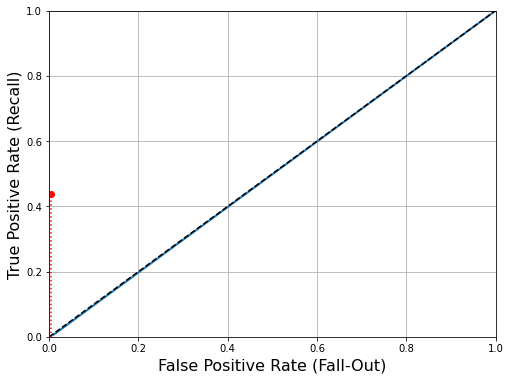

In [35]:
fpr, tpr, thresholds = roc_curve(flat_true_labels_test, flat_predictions_test)
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [36]:
roc_auc_score(flat_true_labels_test, flat_predictions_test)

0.49817013360392354

### Aggregate Predictions to Account Level

In [37]:
# Generate class predictions at the account level 
def predict_tweet_text(predictions, df_bert, df_full):
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert['id'], df, left_index=True, right_index=True)
    df_fm = df_full[['id', 'text','user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_fm['id'] = df_fm['id'].astype('str')
    df_fm['id'] = df_fm['id'].apply(lambda x: "'" + x + "'")
    df_3 = pd.merge(df_fm, df_2, left_on='id', right_on='id')
    df_3.columns = ["id", "text", "user.screen_name", "user.id", "suspended_label", "pred"]
    df_3 = df_3.sort_values(by=['pred'], ascending=False)

    return df_3

In [38]:
test_preds_tweets = predict_tweet_text(flat_predictions_test, full_test_embeddings_all, df_test_f)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
209,'1.2946301275618427e+18',@No1Waila 🤣🤣🤣🤣🤣🤣,HusnainAliMaqs2,1.282364e+18,0,1
6,'1.2782143415362642e+18',#NewProfilePic,PremchandraWah1,1.278187e+18,0,1
0,'1.278734441767207e+18',@ImranKhanPTI me mazor adme ho,MMunir50647063,1.278130e+18,0,0
146,'1.2803695489028874e+18',@jianqiao_hk @PDChinese 就你也算中华儿女？,2j27dAYG3KGQCbf,1.280335e+18,0,0
135,'1.2815472579055903e+18',@ButtTariq15 @Muhamma21899973 اس بیغرت کو کوی ...,IjazAhm41721557,1.280078e+18,0,0


In [39]:
test_preds_tweets.to_csv('test_preds_tweets.csv', index=False, encoding = "utf_8_sig")

In [40]:
# Generate class predictions at the account level 
def predict_account(predictions, df_bert, df_full):
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [41]:
test_account_preds_tweettext = predict_account(flat_predictions_test, full_test_embeddings_all, df_test_f)
test_account_preds_tweettext

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
81,John97242303,0,15,0.017647,0
70,HasanRa98850598,0,12,0.025157,0
252,wishworld_peace,0,9,0.012640,0
202,fWsArCRQJMn0koq,0,7,0.009957,0
69,Ha1Hashmi,0,6,0.010870,0
...,...,...,...,...,...
104,MeerZahoor9,0,0,0.000000,0
105,Mehmood38231195,0,0,0.000000,0
106,Mehvish24536861,1,0,0.000000,0
107,MinZhou233,0,0,0.000000,0


### Confusion Matrix for Account Classification

In [42]:
#report = classification_report(np.array(test_labels), predictions)
report_te = classification_report(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
print(report_te)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       243
           1       0.00      0.00      0.00        21

    accuracy                           0.90       264
   macro avg       0.46      0.49      0.47       264
weighted avg       0.85      0.90      0.87       264



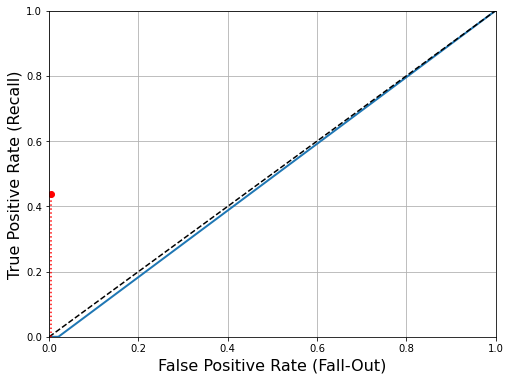

In [43]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [44]:
roc_auc_score(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))

0.4897119341563786

In [45]:
test_account_preds_tweettext.to_csv('test_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")